In [1]:
#############################
# Stock Price Prediction with Enhanced Techniques
#############################

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Time Series Split
from sklearn.model_selection import TimeSeriesSplit

# Sentiment Analysis (Placeholder for actual implementation)
def get_sentiment_scores(text):
    """
    Placeholder function to simulate sentiment analysis.
    In practice, this function should analyze the text and return
    sentiment scores such as polarity, subjectivity, etc.
    """
    # Example: Return random sentiment scores
    return np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()


In [5]:
#############################
# 1) Load and Prepare Data
#############################

# Load stock price data
# df_price = pd.read_csv("AAPL.csv", parse_dates=["date"])
# df_price.sort_values("date", inplace=True)

# # Load news data
# df_news = pd.read_csv("apple_news_data.csv", parse_dates=["date"])
# df_news.sort_values("date", inplace=True)

# # Aggregate news data by date and compute sentiment scores
# df_news['sentiment_polarity'], df_news['sentiment_neg'], df_news['sentiment_neu'], df_news['sentiment_pos'] = zip(*df_news['headline'].apply(get_sentiment_scores))
# df_news_agg = df_news.groupby('Date').mean().reset_index()

# df_merged = pd.merge(df_price, df_news, on="Date", how="inner")  # or "left"

#############################
# 5) Create Technical Indicators
#############################
# Load the merged CSV with Apple prices + sentiment.

csv_file = "merged_news_stock_data.csv"  # adjust if needed

df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Columns in dataset:", df.columns.tolist())
print("Row count:", len(df))
df.head()




Columns in dataset: ['Date', 'title', 'content', 'link', 'symbols', 'tags', 'sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'Close_Price', 'High_Price', 'Low_Price', 'Open_Price', 'Volume']
Row count: 26581


,Date,title,content,link,symbols,tags,sentiment_polarity,sentiment_neg,sentiment_neu,sentiment_pos,Close_Price,High_Price,Low_Price,Open_Price,Volume
0,2016-02-19,Payment Data Systems Announces Apple Pay Suppo...,"SAN ANTONIO, Feb. 19, 2016 (GLOBE NEWSWIRE) ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, PYDS.US, USIO.US","AKIMBO, AKIMBO CARD, APPLE, APPLE PAY, FICENTI...",0.994,0.023,0.869,0.108,21.845985,22.009762,21.791394,21.836887,141496800
1,2017-10-05,New Research: Key Drivers of Growth for Micros...,"NEW YORK, Oct. 05, 2017 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, AMZN.US, INTC.US, MSFT.US, QCOM.US, T...",FUNDAMENTAL MARKETS,0.997,0.008,0.925,0.067,36.384716,36.396424,36.070955,36.101392,85135200
2,2017-11-27,"Factors of Influence in 2018, Key Indicators a...","NEW YORK, Nov. 27, 2017 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, CSCO.US, GD.US, HPE.US, NVDA.US, S.US",FUNDAMENTAL MARKETS,0.997,0.008,0.926,0.065,40.909874,41.142518,40.733629,41.135469,82867200
3,2017-11-30,"BioTelemetry, Inc. Enters Agreement to Provide...","MALVERN, Pa., Nov. 30, 2017 (GLOBE NEWSWIRE)...",https://www.globenewswire.com/news-release/201...,"AAPL.US, BEAT.US","BIOTELEMETRY, INC, NASDAQ:BEAT",0.989,0.021,0.804,0.174,40.383492,40.451638,39.582166,40.049799,166108800
4,2018-01-31,Investor Expectations to Drive Momentum within...,"NEW YORK, Jan. 31, 2018 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, AVHI.US, FARM.US, GM.US, SGRY.US",FUNDAMENTAL MARKETS,0.995,0.009,0.937,0.054,39.344833,39.582178,39.126292,39.213238,129915600


In [7]:
#############################
# 2) Feature Engineering
#############################

# Compute technical indicators
def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()

df['RSI'] = compute_rsi(df['Close_Price'])
macd_line, macd_signal, macd_hist = compute_macd(df['Close_Price'])
df['MACD_line'], df['MACD_signal'], df['MACD_hist'] = macd_line, macd_signal, macd_hist
df['MA20'] = compute_ma(df['Close_Price'])

df.dropna(inplace=True)

df['Close_next'] = df['Close_Price'].shift(-1)
df.dropna(inplace=True)

In [8]:
#############################
# 3) Train-Test Split
#############################

ts_split = TimeSeriesSplit(n_splits=5)
feature_cols = ['RSI', 'MACD_line', 'MACD_signal', 'MACD_hist', 'MA20', 'sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos']
X = df[feature_cols]
y = df['Close_next']

In [9]:
#############################
# 4) Model Training and Evaluation
#############################

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

results = {}
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Linear Regression
    lr_model = LinearRegression()
    results['LinearRegression'] = evaluate_model(lr_model, X_train, X_test, y_train, y_test)
    
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    results['RandomForest'] = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    results['XGBoost'] = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
    
    # Neural Network
    nn_model = Sequential([
        Dense(32, input_dim=X_train.shape[1], activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    nn_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    y_pred_nn = nn_model.predict(X_test).flatten()
    results['NeuralNetwork'] = (sqrt(mean_squared_error(y_test, y_pred_nn)), r2_score(y_test, y_pred_nn))


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


In [10]:

#############################
# 5) Results Comparison
#############################

for model, (rmse, r2) in results.items():
    print(f"{model}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")



LinearRegression: RMSE = 0.6655, R2 = 0.9941
RandomForest: RMSE = 1.4601, R2 = 0.9716
XGBoost: RMSE = 0.7948, R2 = 0.9916
NeuralNetwork: RMSE = 0.7373, R2 = 0.9928


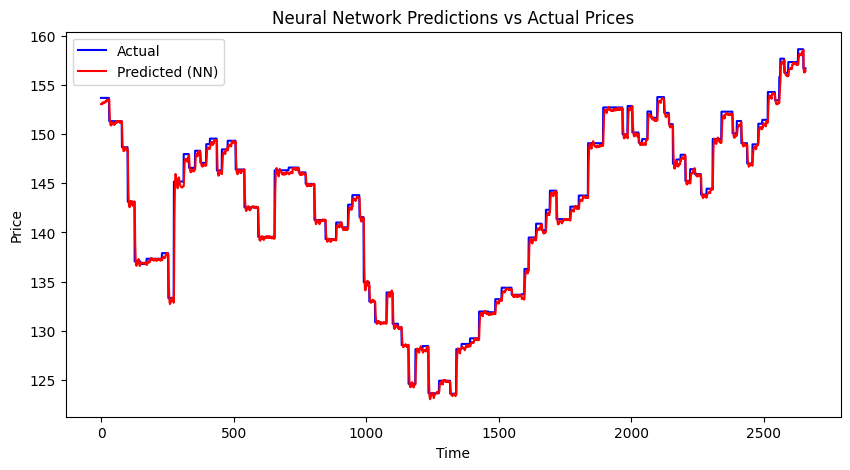

In [ ]:
#############################
# 6) Visualization
#############################

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_nn, label='Predicted (NN)', color='red')
plt.title("Neural Network Predictions vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()